In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tiktoken

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers of transformer blocks
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            nn.GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    def forward(self, x):
        return self.ff(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # d_out: output dimension
        # head_dim: is the dimension of context vector before we concatenate them
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"  
        self.head_dim = d_out // num_heads
        self.d_out = d_out
        self.num_heads = num_heads
        
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x) # shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(cfg['emb_dim'], bias=cfg['qkv_bias'])
        self.layer_norm2 = nn.LayerNorm(cfg['emb_dim'], bias=cfg['qkv_bias'])
        self.attn = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            dropout=cfg['drop_rate'],
            num_heads=cfg['n_heads'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.dropout = nn.Dropout(cfg['drop_rate'])
        
    def forward(self, x):
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut

        shortcut = x
        x = self.layer_norm2(x)
        x = self.dropout(self.ff(x))
        x += shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = nn.LayerNorm(cfg['emb_dim'], bias=cfg['qkv_bias'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embed = self.token_emb(in_idx)
        pos_embed = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embed + pos_embed
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        x = self.out_head(x)
        return x

    # check devices here
    def generate(self, idx, max_new_tokens, context_size, device, temperature=0.0, top_k=None, eos_id=None):
        for _ in range(max_new_tokens):
            idx = idx.to(device)
            idx_cond = idx[:, -context_size:]
            with torch.no_grad():
                logits = self(idx_cond)
            
            logits = logits[:, -1, :] # output embed of the last token dim: (batch, vocab_size)
            if top_k is not None:
                top_logits, top_pos = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                # we use instead the following code
                tmp_logits = torch.empty_like(logits)
                tmp_logits.copy_(logits)
                logits = torch.full_like(logits, -torch.inf) # tensor contains infinity values only
                logits[:, top_pos] = tmp_logits[:, top_pos]
            
            if temperature > 0.0:
                logits = logits / temperature
                probs = torch.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)
    
            if idx_next == eos_id:
                break
                
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        
        for idx in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[idx : idx+max_length]
            target_chunk = token_ids[idx+1 : idx+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, 
                         shuffle=True, drop_last=True, num_workers=0):
    
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    # print(len(dataset))
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle,
                           num_workers=num_workers, drop_last=drop_last)
    return dataloader

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

# Model training:

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

with open('/kaggle/input/shakespeare-plus-verdict/verdict_plus_shakespeare.txt', 'r') as f:
    txt = f.read()

len(txt), txt[:200]

(1135875,
 'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a')

In [4]:
torch.manual_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {device}')
train_ratio = 0.85
split_indx = int(train_ratio * len(txt))
train_data = txt[:split_indx]
val_data = txt[split_indx:]

train_loader = create_dataloader_v1(
    train_data,
    batch_size=16,
    max_length=16,
    stride=12,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=16,
    max_length=16,
    stride=12,
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Device is: cuda


In [5]:
len(train_loader), len(val_loader)

(1504, 283)

In [6]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0.
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))

    for i, (input_batch, output_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, output_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [7]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                      eval_freq, eval_iter, start_context, tokenizer, early_stopping):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader,
                                                      device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f'Epoch {epoch+1} (Step {global_step:06d}): '
                     f'Train loss {train_loss:.3f}, Val loss {val_loss:.3f}')

        generate_and_print_sample(model, tokenizer, device, start_context)
        early_stopping(val_loss, model)
        # Check early stopping condition
        if early_stopping.early_stop:
            early_stopping.load_best_model(model)
            print('Early stopping condition executed')
            break
    
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdims=True)
        idx = torch.cat((idx, idx_next), dim=-1)
    
    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, 50, context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' '))
    model.train()

In [8]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension because model works with batches not 1D vector
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [9]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f'Initial Losses:\nTrain Loss: {train_loss}\nValidation Loss: {val_loss}')

Initial Losses:
Train Loss: 10.96916237536897
Validation Loss: 10.96435064983031


In [10]:
len(train_loader), len(val_loader)

(1504, 283)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
num_epochs, eval_freq, eval_iter = 23, 250, 16
start_context = 'Every effort moves you'
early_stopping = EarlyStopping(patience=10)

train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader,optimizer, device,
    num_epochs, eval_freq, eval_iter, start_context, tokenizer, early_stopping)

Epoch 1 (Step 000000): Train loss 9.515, Val loss 9.334
Epoch 1 (Step 000250): Train loss 5.551, Val loss 5.308
Epoch 1 (Step 000500): Train loss 5.199, Val loss 4.801
Epoch 1 (Step 000750): Train loss 4.852, Val loss 4.619
Epoch 1 (Step 001000): Train loss 4.797, Val loss 4.566
Epoch 1 (Step 001250): Train loss 4.667, Val loss 4.445
Epoch 1 (Step 001500): Train loss 4.561, Val loss 4.382
Every effort moves you, And so, and so, and so, and so, and so, and so, and so, and so, and so, and so, and so, and so, and so, and so, and so, and so,
Epoch 2 (Step 001750): Train loss 4.455, Val loss 4.404
Epoch 2 (Step 002000): Train loss 4.365, Val loss 4.321
Epoch 2 (Step 002250): Train loss 4.343, Val loss 4.314
Epoch 2 (Step 002500): Train loss 4.233, Val loss 4.322
Epoch 2 (Step 002750): Train loss 4.155, Val loss 4.270
Epoch 2 (Step 003000): Train loss 4.241, Val loss 4.229
Every effort moves you, And therefore I'll not to the king.  DUCHESS OF YORK: DUKE VINCENTIO: DUKE VINCENTIO: DUKE VINCE

In [12]:
token_ids = model.generate(
        idx=text_to_token_ids("Every effort moves you", tokenizer),
        max_new_tokens=30,
        context_size=GPT_CONFIG_124M["context_length"],
        device=device,
        temperature=1.4,
        top_k=25,
        eos_id='<|endoftext|>'
)
print('Output text:')
print(token_ids_to_text(token_ids, tokenizer))

Output text:
Every effort moves you,
Most noble prince, with that opinion shows majesty,
I play the day some call'd the warlike Marcius withal sea, and


In [13]:
token_ids = model.generate(
        idx=text_to_token_ids("Every effort moves you", tokenizer),
        max_new_tokens=200,
        context_size=GPT_CONFIG_124M["context_length"],
        device=device,
        temperature=2,
        top_k=20,
        eos_id='<|endoftext|>'
)
print('Output text:')
print(token_ids_to_text(token_ids, tokenizer))

Output text:
Every effort moves you.
Come, ladies. far comes the caria forgiveness? The day was half his last!
sound into it to him; say with him.
Your prattsously: come about him to be out of his place; then the market-tender of him! And that givesves for tr frozen man oracle should you mock it presently.' Heland, you know it then be't look that does forget with fire.
He speak again, to Berkeley, wept, we will keep him.
beown find us. How. How many knave the next man use's again: he was anon comes unto himself to give you befall desired the people any sword to keep your bed be known! He chide us not. If God keep your resolution make you common deputy here was an executioner be good Comin's other.
A shepherd make take us thus. But out our reward us take you are his sister'ser beards be much of


In [14]:
token_ids = model.generate(
        idx=text_to_token_ids("How are you, are you", tokenizer),
        max_new_tokens=30,
        context_size=GPT_CONFIG_124M["context_length"],
        device=device,
        temperature=2,
        top_k=20,
        eos_id='<|endoftext|>'
)
print('Output text:')
print(token_ids_to_text(token_ids, tokenizer))

Output text:
How are you, are you that be 'ensed; thank me both
than the court and be't is for my country: what I shall I must report forsworn;


In [15]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

In [16]:
torch.save(model.state_dict(), '/kaggle/working/model.pth')

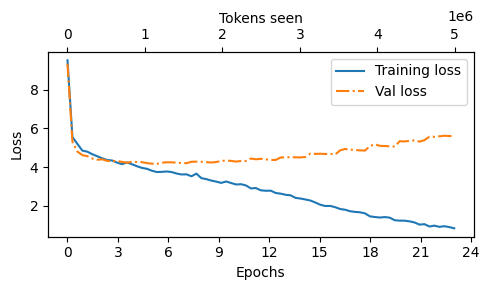

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label='Training loss')
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label='Val loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens seen')

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)